In [67]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import top_k_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [68]:
device = 'CM4'

In [69]:
def downCount(similarity, truth: pd.DataFrame, classes):
    downlink_required = {}
    for i, cls in enumerate(classes):
        downlink_required[cls] = {'track': []}
        downlink_required[cls]['count'] = {}
        point_data = {'x': [], 'y':[]}

        count_df = truth.assign(sim=similarity[:,i]).sort_values(by=['sim'], ascending=False)

        cls_count = 0
        count = 0
        for j, row in count_df.iterrows():
            count += 1
            if row['class'] == cls:
                cls_count+=1
                point_data['x'].append(count)
                point_data['y'].append(cls_count)
            downlink_required[cls]["track"].append(cls_count)

            if cls_count == len(count_df)/len(classes):
                downlink_required[cls]['count']['100%'] = count
                break
        m, b = np.polyfit(point_data['x'], point_data['y'], 1)
        downlink_required[cls]['error'] = 1 - m

    return downlink_required

In [70]:
test_data = pd.read_csv('./PrioEval.csv', sep='\t')
y_true = test_data['class_id'].values

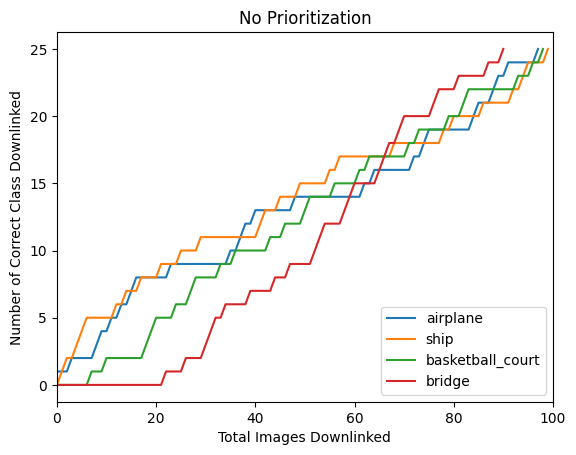

In [71]:
similarity = np.flip(np.arange(len(test_data)))
similarity = np.stack([similarity]*4).T
downData = downCount(similarity, test_data, ['airplane', 'ship', 'basketball_court', 'bridge'])
plt.title(f'No Prioritization')
plt.xlim(0,100)
plt.xlabel('Total Images Downlinked')
plt.ylabel('Number of Correct Class Downlinked')
plt.plot(downData['airplane']['track'], label='airplane')
plt.plot(downData['ship']['track'], label='ship')
plt.plot(downData['basketball_court']['track'], label='basketball_court')
plt.plot(downData['bridge']['track'], label='bridge')
plt.legend(loc="lower right")
plt.show()

In [72]:
print('Downlink by completion percent:')
print('Airplane: ', downData['airplane']['count'])
print('Ship: ', downData['ship']['count'])
print('Basketball Court: ', downData['basketball_court']['count'])
print('Bridge: ', downData['bridge']['count'])

Downlink by completion percent:
Airplane:  {'100%': 98}
Ship:  {'100%': 100}
Basketball Court:  {'100%': 99}
Bridge:  {'100%': 91}


In [73]:
print('Error:')
print('Airplane: ', downData['airplane']['error'])
print('Ship: ', downData['ship']['error'])
print('Basketball Court: ', downData['basketball_court']['error'])
print('Bridge: ', downData['bridge']['error'])

Error:
Airplane:  0.778090252841683
Ship:  0.7847951497229078
Basketball Court:  0.7399567328251956
Bridge:  0.6270370017413603


In [74]:
y_true

array([0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 2, 2, 2, 1,
       3, 0, 2, 1, 3, 2, 2, 1, 3, 3, 3, 2, 3, 0, 2, 0, 0, 3, 0, 1, 1, 2,
       3, 1, 2, 3, 0, 1, 2, 2, 3, 3, 3, 1, 2, 1, 3, 3, 3, 2, 0, 2, 0, 3,
       3, 3, 1, 3, 3, 2, 0, 2, 0, 0, 3, 3, 1, 2, 1, 3, 2, 2, 0, 0, 1, 3,
       0, 0, 3, 0, 1, 2, 1, 1, 2, 0, 2, 1])

In [75]:
base_model = 'RN50'
with open(f'./CLIP/sim_{base_model}_{device}.pkl', 'rb') as file:
    similarity = pickle.load(file)
similarity.shape

(4, 100)

In [76]:
top_k_stats = []
# Class-wise
top_k_stats.append({'k': 1, 'score': top_k_accuracy_score(y_true, similarity.T, k=1)})
top_k_stats.append({'k': 2, 'score': top_k_accuracy_score(y_true, similarity.T, k=2)})
top_k_stats.append({'k': 3, 'score': top_k_accuracy_score(y_true, similarity.T, k=3)})
top_k_stats

[{'k': 1, 'score': np.float64(1.0)},
 {'k': 2, 'score': np.float64(1.0)},
 {'k': 3, 'score': np.float64(1.0)}]

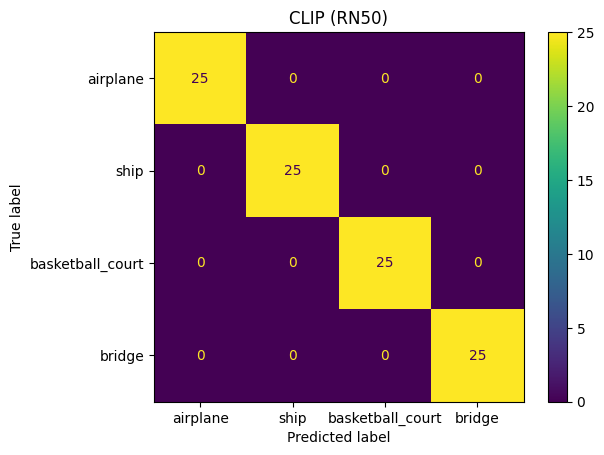

In [77]:
cm = confusion_matrix(y_true, np.argmax(similarity.T, axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['airplane', 'ship', 'basketball_court', 'bridge'] )
cm_display.plot()
plt.title(f'CLIP ({base_model})')
plt.show()

In [78]:
avg_correct_cos = 0
for i, sim in enumerate(similarity.T):
    avg_correct_cos += sim[y_true[i]]

avg_correct_cos /= len(similarity.T)
avg_correct_cos

np.float32(0.6758385)

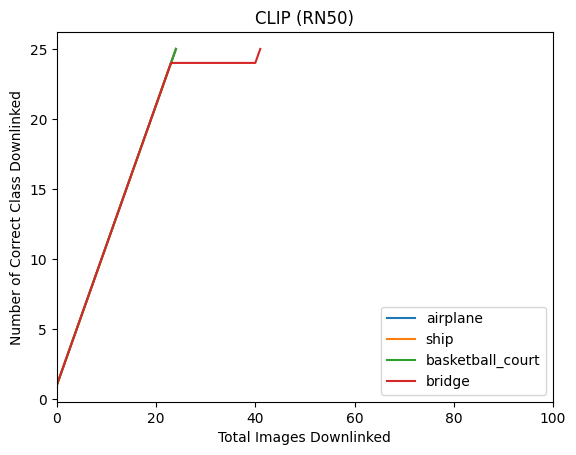

In [79]:
plt.title(f'CLIP ({base_model})')
downData = downCount(similarity.T, test_data, ['airplane', 'ship', 'basketball_court', 'bridge'])
plt.xlim(0,100)
plt.xlabel('Total Images Downlinked')
plt.ylabel('Number of Correct Class Downlinked')
plt.plot(downData['airplane']['track'], label='airplane')
plt.plot(downData['ship']['track'], label='ship')
plt.plot(downData['basketball_court']['track'], label='basketball_court')
plt.plot(downData['bridge']['track'], label='bridge')
plt.legend(loc="lower right")
plt.show()

In [80]:
print('Downlink by completion percent:')
print('Airplane: ', downData['airplane']['count'])
print('Ship: ', downData['ship']['count'])
print('Basketball Court: ', downData['basketball_court']['count'])
print('Bridge: ', downData['bridge']['count'])

Downlink by completion percent:
Airplane:  {'100%': 25}
Ship:  {'100%': 25}
Basketball Court:  {'100%': 25}
Bridge:  {'100%': 42}


In [81]:
print('Error:')
print('Airplane: ', downData['airplane']['error'])
print('Ship: ', downData['ship']['error'])
print('Basketball Court: ', downData['basketball_court']['error'])
print('Bridge: ', downData['bridge']['error'])

Error:
Airplane:  2.220446049250313e-16
Ship:  2.220446049250313e-16
Basketball Court:  2.220446049250313e-16
Bridge:  0.24248529293254883


In [82]:
base_model = '1280'
with open(f'./YOLO/sim_{base_model}_{device}.pkl', 'rb') as file:
    similarity = pickle.load(file)
similarity.shape

(100, 4)

In [83]:
top_k_stats = []
# Class-wise
top_k_stats.append({'k': 1, 'score': top_k_accuracy_score(y_true, similarity, k=1)})
top_k_stats.append({'k': 2, 'score': top_k_accuracy_score(y_true, similarity, k=2)})
top_k_stats.append({'k': 3, 'score': top_k_accuracy_score(y_true, similarity, k=3)})
top_k_stats

[{'k': 1, 'score': np.float64(0.66)},
 {'k': 2, 'score': np.float64(0.89)},
 {'k': 3, 'score': np.float64(0.97)}]

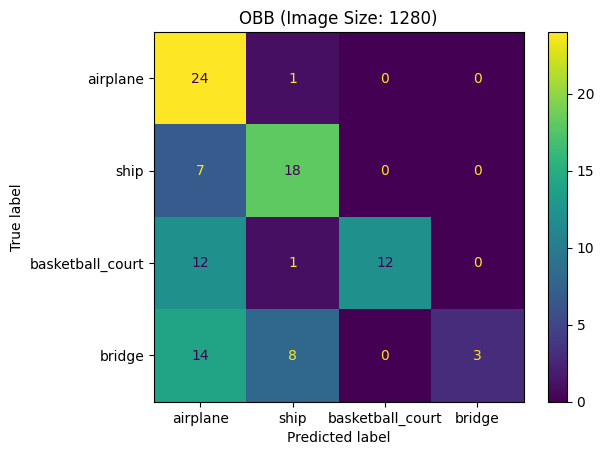

In [84]:
cm = confusion_matrix(y_true, np.argmax(similarity, axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['airplane', 'ship', 'basketball_court', 'bridge'] )
cm_display.plot()
plt.title(f'OBB (Image Size: {base_model})')
plt.show()

In [85]:
avg_correct_cos = 0
for i, sim in enumerate(similarity):
    avg_correct_cos += sim[y_true[i]]

avg_correct_cos /= len(similarity)
avg_correct_cos

np.float64(0.22260126604597733)

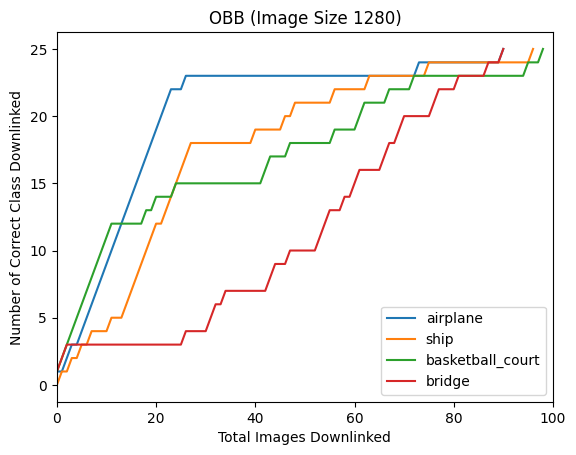

In [86]:
downData = downCount(similarity, test_data, ['airplane', 'ship', 'basketball_court', 'bridge'])
plt.title(f'OBB (Image Size {base_model})')
plt.xlim(0,100)
plt.xlabel('Total Images Downlinked')
plt.ylabel('Number of Correct Class Downlinked')
plt.plot(downData['airplane']['track'], label='airplane')
plt.plot(downData['ship']['track'], label='ship')
plt.plot(downData['basketball_court']['track'], label='basketball_court')
plt.plot(downData['bridge']['track'], label='bridge')
plt.legend(loc="lower right")
plt.show()

In [87]:
print('Downlink by completion percent:')
print('Airplane: ', downData['airplane']['count'])
print('Ship: ', downData['ship']['count'])
print('Basketball Court: ', downData['basketball_court']['count'])
print('Bridge: ', downData['bridge']['count'])

Downlink by completion percent:
Airplane:  {'100%': 91}
Ship:  {'100%': 97}
Basketball Court:  {'100%': 99}
Bridge:  {'100%': 91}


In [88]:
print('Error:')
print('Airplane: ', downData['airplane']['error'])
print('Ship: ', downData['ship']['error'])
print('Basketball Court: ', downData['basketball_court']['error'])
print('Bridge: ', downData['bridge']['error'])

Error:
Airplane:  0.7325090470446322
Ship:  0.7177166682734022
Basketball Court:  0.7760504363472156
Bridge:  0.7218933859019825
